## ライブラリー「sktime」を使った時系列分析

In [1]:
# 基本ライブラリー
import numpy as np
import pandas as pd
import seaborn as sns
# sktime系
from sktime.datasets import load_airline #サンプルデータ（航空機の乗客数）
from sktime.forecasting.model_selection import temporal_train_test_split #時系列の学習データとテストデータの生成
from sktime.forecasting.arima import ARIMA, AutoARIMA #ARIMAモデル
from sktime.forecasting.exp_smoothing import ExponentialSmoothing #ESモデル
from sktime.forecasting.ets import AutoETS #ETSモデル
from sktime.forecasting.tbats import TBATS #TBATSモデル
from sktime.forecasting.bats import BATS #BATSモデル
from sktime.forecasting.naive import NaiveForecaster #NaiveForecaster
from sktime.forecasting.compose import EnsembleForecaster #アンサンブル
from sktime.utils.plotting import plot_series #グラフ化
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error #予測精度MAPE

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
y = load_airline()
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

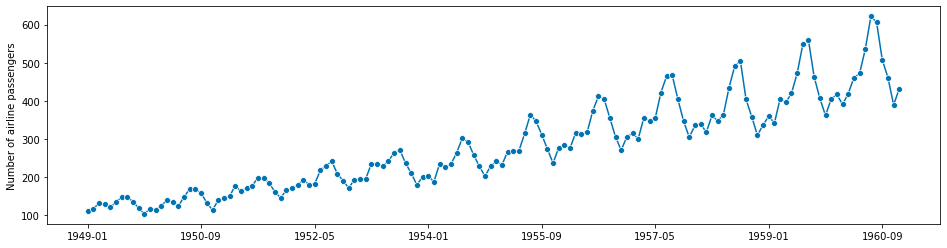

In [3]:
plot_series(y)

In [4]:
y_train, y_test = temporal_train_test_split(y,test_size=36)

In [5]:
y_train

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1957-08    467.0
1957-09    404.0
1957-10    347.0
1957-11    305.0
1957-12    336.0
Freq: M, Name: Number of airline passengers, Length: 108, dtype: float64

In [6]:
y_test

Period
1958-01    340.0
1958-02    318.0
1958-03    362.0
1958-04    348.0
1958-05    363.0
1958-06    435.0
1958-07    491.0
1958-08    505.0
1958-09    404.0
1958-10    359.0
1958-11    310.0
1958-12    337.0
1959-01    360.0
1959-02    342.0
1959-03    406.0
1959-04    396.0
1959-05    420.0
1959-06    472.0
1959-07    548.0
1959-08    559.0
1959-09    463.0
1959-10    407.0
1959-11    362.0
1959-12    405.0
1960-01    417.0
1960-02    391.0
1960-03    419.0
1960-04    461.0
1960-05    472.0
1960-06    535.0
1960-07    622.0
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, dtype: float64

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

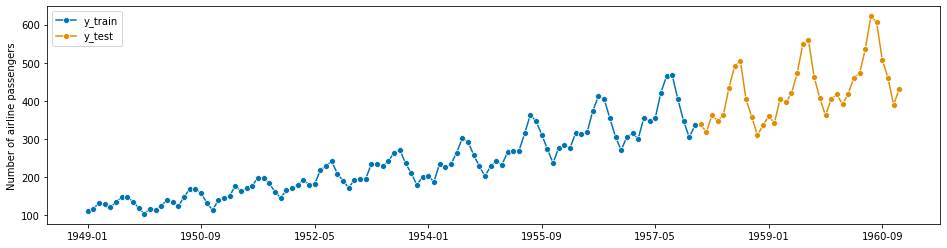

In [7]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [8]:
# ARIMAモデル自動構築
model_AutoARIMA = AutoARIMA(sp=12, suppress_warnings=True)
model_AutoARIMA.fit(y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [9]:
# 予測期間の添え字
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [10]:
# 予測実施
y_pred = model_AutoARIMA.predict(fh)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

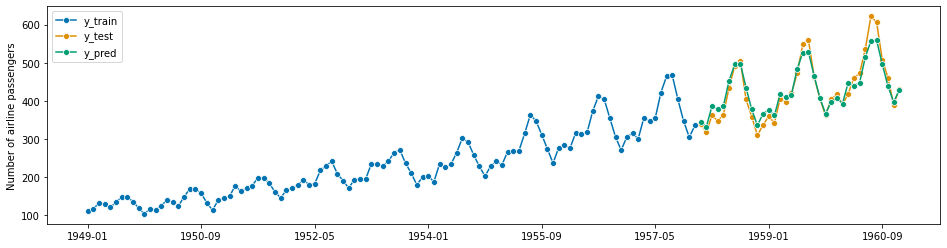

In [11]:
# 予測結果のグラフ化
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [12]:
# 予測精度検証：MAPE（平均絶対パーセント誤差）
mean_absolute_percentage_error(y_test, y_pred)

0.041170623702305884

0.06315305335358352

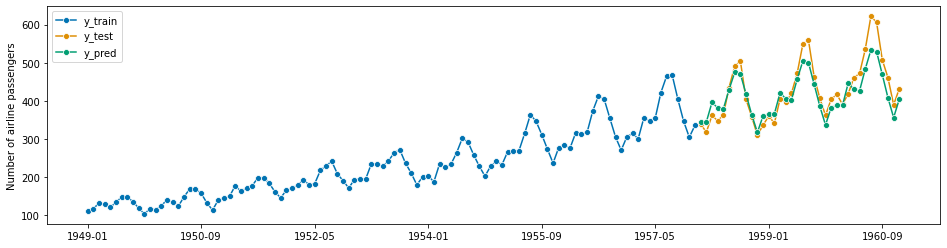

In [13]:
# AutoETS
model_AutoETS = AutoETS(auto=True, sp=12, n_jobs=-1)
model_AutoETS.fit(y_train)
y_pred = model_AutoETS.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

0.042571058181905735

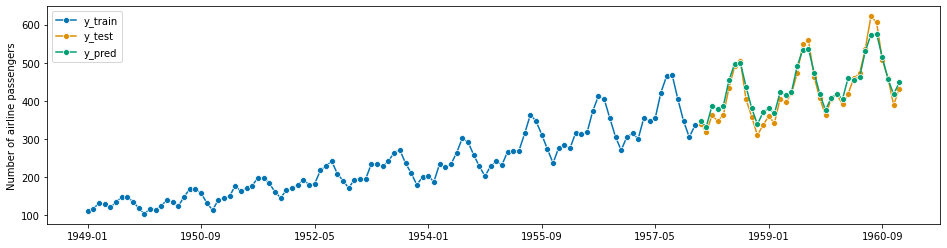

In [14]:
# ARIMA
model_arima = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)
model_arima.fit(y_train)
y_pred = model_arima.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

0.08689500339006484

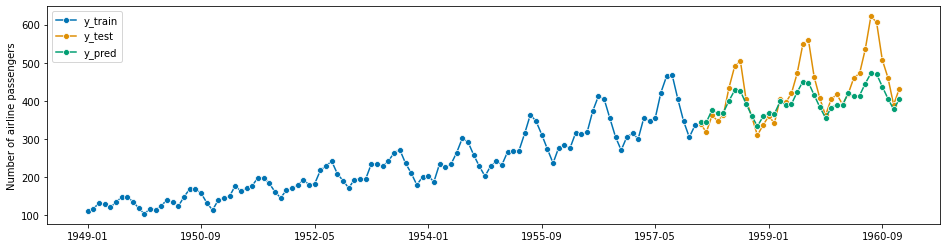

In [15]:
# BATS
model_BATS = BATS(sp=12, use_trend=True, use_box_cox=False)
model_BATS.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = model_BATS.predict(fh, return_pred_int=True, alpha=alpha)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

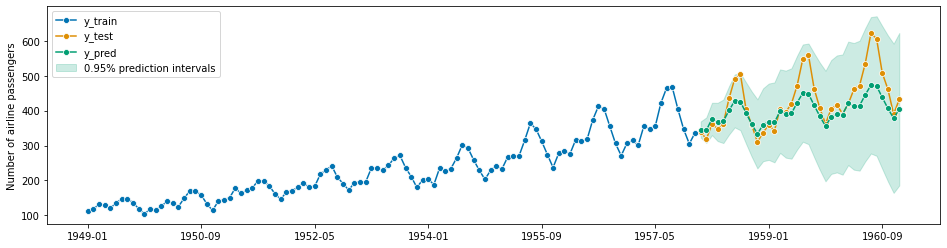

In [16]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

0.0849335347704996

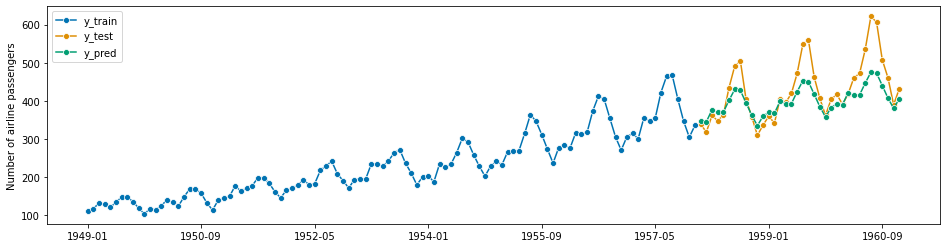

In [17]:
# TBATS
model_TBATS = TBATS(sp=12, use_trend=True, use_box_cox=False)
model_TBATS.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = model_TBATS.predict(fh, return_pred_int=True, alpha=alpha)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred)

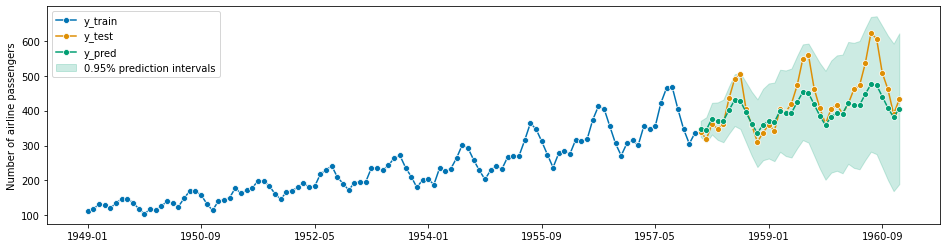

In [18]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

0.145427686270316

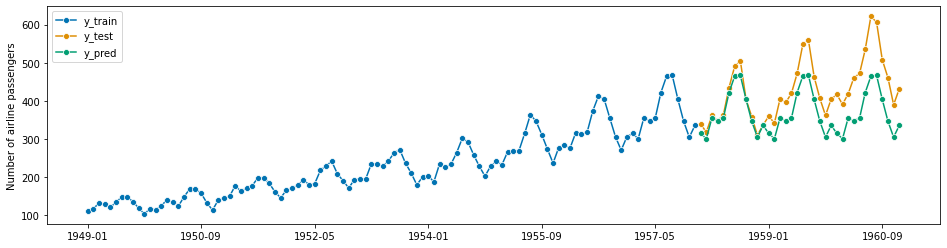

In [19]:
# NaiveForecaster
model_Naive = NaiveForecaster(strategy="last", sp=12)
model_Naive.fit(y_train)
y_pred = model_Naive.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

0.05108249778167784

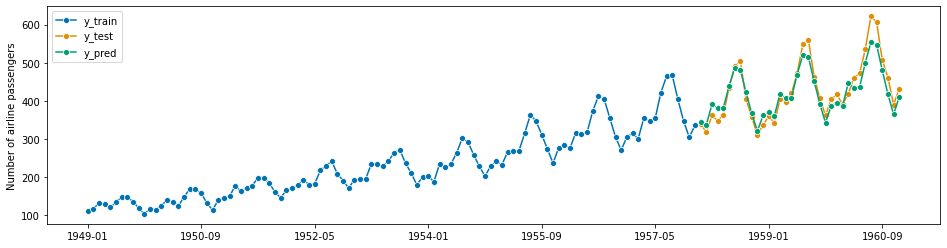

In [20]:
# ExponentialSmoothing
model_ES = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
model_ES.fit(y_train)
y_pred = model_ES.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)